In [8]:
import torch
import numpy as np
from transformers import AutoTokenizer, BertTokenizer
from datasets import load_dataset
from tqdm.notebook import tqdm
from importlib import reload
import matplotlib.pyplot as plt
import pickle
import lzma
import yaml
import pandas as pd
from scipy.stats import spearmanr, pearsonr

# SELECTED_GPU = 0
# if torch.cuda.is_available():
#     # Tell PyTorch to use the GPU.    
#     device = torch.device("cuda:{}".format(SELECTED_GPU))
#     print('There are %d GPU(s) available.' % torch.cuda.device_count())
#     print('We will use the GPU:', torch.cuda.get_device_name(SELECTED_GPU))
# else:
#     device = "cpu"

globencs_v2_dir = "/home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise"
globencs_dir = "/home/modaresi/projects/globenc_analysis/outputs/globencs"
saliencies_dir = "/home/modaresi/projects/globenc_analysis/outputs/saliencies"
configs = {
    "mnli-val": {
        "globenc_path": lambda epoch : f"{globencs_dir}/mnli-e{epoch}_validation_matched_bert-base-uncased.pickle",
        "globenc_v2_path": lambda epoch : f"{globencs_v2_dir}/mnli-e{epoch}_validation_matched_bert-base-uncased.pickle",
        "saliency_path": lambda step : f"{saliencies_dir}/mnli_bert-base-uncased_0001_SEED0042_checkpoint-{step}.npy",
        "hf_ds": "mnli",
    },
    "sst2-val": {
        "globenc_path": lambda epoch : f"{globencs_dir}/sst2-e{epoch}_validation_bert-base-uncased.pickle",
        "globenc_v2_path": lambda epoch : f"{globencs_v2_dir}/sst2-e{epoch}_validation_bert-base-uncased.pickle",
        "saliency_path": lambda step : f"{saliencies_dir}/sst2_bert-base-uncased_0001_SEED0042_checkpoint-{step}.npy",
        "hf_ds": "mnli",
    }
}

CONFIG_NAME = "mnli-val"
CONFIG = configs[CONFIG_NAME]
EPOCH = 5
STEP = 61360

In [2]:
def load_pickle(path, no_cls=False, no_sep=False):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    if no_cls:
        data["tokens"] = [d[1:] for d in data["tokens"]]
        data["globenc"] = [np.array(d)[:, 1:] for d in data["globenc"]]
    if no_sep:
        data["tokens"] = [d[:-1] for d in data["tokens"]]
        data["globenc"] = [np.array(d)[:, :-1] for d in data["globenc"]]
    data = pd.DataFrame(data)
    before_size = len(data)
    data = data[data["tokens"].map(len) > 1]
    after_size = len(data)
    print(f"Read {path}: {before_size}->{after_size} ")
    return data.to_dict(orient="list"), data.index

In [3]:
globencs, DATASET_KEEP_IDX = load_pickle(CONFIG["globenc_path"](EPOCH), no_cls=True, no_sep=True)

Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e5_validation_matched_bert-base-uncased.pickle: 9815->9815 


In [4]:
saliencies = np.load(CONFIG["saliency_path"](STEP))
saliencies.shape

(9815, 128)

In [5]:
spearmans = []

for i in tqdm(range(len(saliencies))):
    zero_indices = np.where(saliencies[i]==0.0)[0]
    spearmans.append(pearsonr(
        globencs["globenc"][i][0],
        saliencies[i][1:zero_indices[0]-1 if len(zero_indices) > 0 else len(saliencies[i])-1]
    )[0])

  0%|          | 0/9815 [00:00<?, ?it/s]

In [6]:
np.mean(spearmans)

0.7334786331446184

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8cf15ab790>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8cf15abdd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8cf15ab550>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8cf15474d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8cf1547810>],
 'means': []}

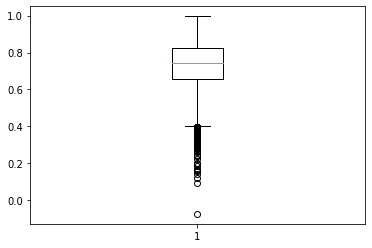

In [9]:
plt.boxplot(spearmans)

In [10]:
globencs_v2, DATASET_KEEP_IDX = load_pickle(CONFIG["globenc_v2_path"](EPOCH), no_cls=True, no_sep=True)

Read /home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise/mnli-e5_validation_matched_bert-base-uncased.pickle: 9815->9815 


In [14]:
spearmans = []

for i in tqdm(range(len(saliencies))):
    zero_indices = np.where(saliencies[i]==0.0)[0]
    spearmans.append(pearsonr(
        globencs_v2["globenc"][i][0],
        saliencies[i][1:zero_indices[0]-1 if len(zero_indices) > 0 else len(saliencies[i])-1]
    )[0])

  0%|          | 0/9815 [00:00<?, ?it/s]

In [15]:
np.mean(spearmans)

0.6919210087977724

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8cf051e710>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8cf0525290>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8cf051b950>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8cf052d0d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8cf0531c50>],
 'means': []}

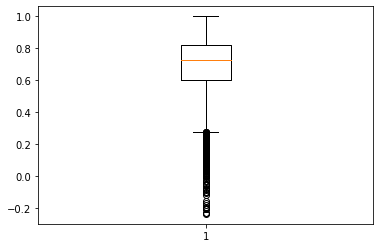

In [16]:
plt.boxplot(spearmans)

In [37]:
globencs_v2["globenc"][2273][0] / globencs_v2["globenc"][2273][0].sum()

array([0.15651974, 0.07549041, 0.17119136, 0.07975227, 0.06964646,
       0.0764088 , 0.07232241, 0.08714885, 0.08571834, 0.12580132],
      dtype=float32)

In [36]:
saliencies[2273][1:11] / saliencies[2273][1:11].sum()

array([0.10450382, 0.13512684, 0.10423704, 0.13808046, 0.07613528,
       0.1273203 , 0.11021214, 0.06423578, 0.10371768, 0.03643072],
      dtype=float32)

In [39]:
globencs_v2["tokens"][2273]

['football',
 'and',
 'baseball',
 'and',
 '[SEP]',
 'both',
 'football',
 'and',
 'baseball',
 '.']

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4830f96590>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4830f96c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4830f96350>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4830f97350>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4830f97690>],
 'means': []}

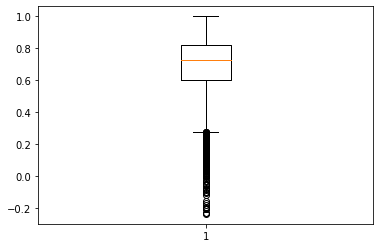

In [22]:
import matplotlib.pyplot as plt
plt.boxplot(spearmans)

In [27]:
np.median(spearmans)

0.7232285951572017